In [1]:
import yaml
import sys
import os
os.chdir('/home/jonfrey/PLR3')
sys.path.insert(0, os.getcwd())
sys.path.append(os.path.join(os.getcwd() + '/src'))
sys.path.append(os.path.join(os.getcwd() + '/lib'))

from loaders_v2 import GenericDataset
exp_cfg_path = '/home/jonfrey/PLR3/yaml/exp/exp_ws_deepim_debug_natrix.yml'
env_cfg_path = '/home/jonfrey/PLR3/yaml/env/env_natrix_jonas.yml'

def load_from_file(p):
    if os.path.isfile(p):
        with open(p, 'r') as f:
            data = yaml.safe_load(f)
    else:
        raise ValueError
    return data

exp = load_from_file(exp_cfg_path)
env = load_from_file(env_cfg_path)

dataset_train = GenericDataset(
    cfg_d=exp['d_train'],
    cfg_env=env)


In [2]:
batch = dataset_train[0][0]

points, choose, img, target, model_points, idx = batch[0:6]
depth_img, label_img, img_orig, cam = batch[6:10]
gt_rot_wxyz, gt_trans, unique_desig = batch[10:13]
real_img, render_img, real_d, render_d, gt_label_cropped, pred_rot_wxyz, pred_trans, pred_points, h_render, img_ren = batch[13:]
img_ren = img_ren[0]
    
# TODO
"""
Idea gt of the rendered image.  
gt in the real image. 

Backproject one point of the model_point. 
Store the corrspondence in the orginal image. 
-> Original VM pose!
-> 1. Color backproject point map
-> Apply the full bounding box projection stuff
"""


/home/jonfrey/PLR3/src/helper/bounding_box.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  masked_idx = (d != 0).nonzero()


'\nIdea gt of the rendered image.  \ngt in the real image. \n\nBackproject one point of the model_point. \nStore the corrspondence in the orginal image. \n-> Original VM pose!\n-> 1. Color backproject point map\n-> Apply the full bounding box projection stuff\n'

In [3]:
img_ren.shape

torch.Size([480, 640, 3])

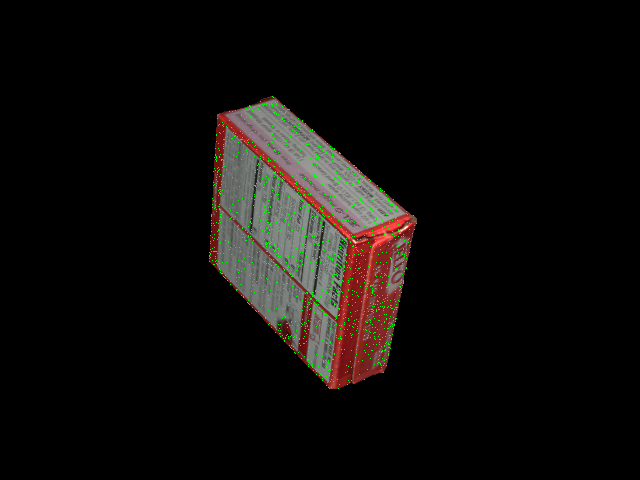

tensor([[ 0.0234, -0.6309,  0.7755, -0.0306],
        [ 0.9331, -0.2646, -0.2434, -0.0080],
        [ 0.3588,  0.7293,  0.5825,  0.5926],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
tensor([0.5517, 0.6188, 0.5947,  ..., 0.5472, 0.6357, 0.5781])


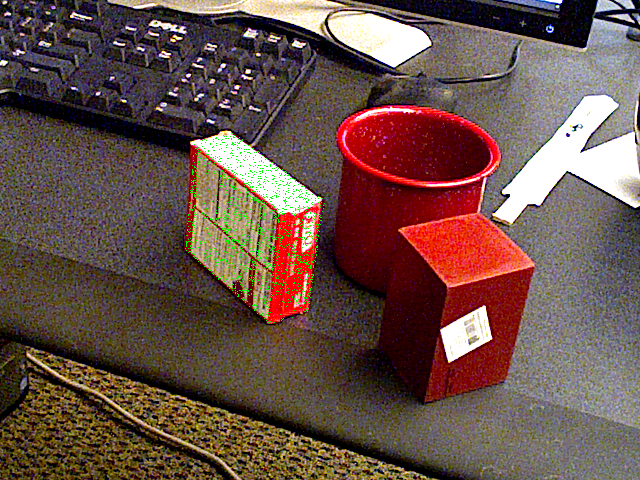

tensor([[27, 87],
        [ 6, 51],
        [-4, 60],
        ...,
        [36, 65],
        [ 8, 43],
        [50, 53]])
torch.Size([2300, 2])
torch.Size([2300, 2])


/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=53,48 m=2300 fp=10873.491096 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


mapping max66 min -36


/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=47,54 m=2300 fp=272.464966 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [4]:
import torch
from helper import backproject_points
import numpy as np
from PIL import Image, ImageDraw
from rotations import quat_to_rot
h,w,_ = img_ren.shape
model_points_h = torch.ones((model_points.shape[0],4))
model_points_h[:,:3] = model_points 
render_gt = model_points_h @ h_render[0].T
uv1 = backproject_points(render_gt[:,:3],cam[2],cam[3],cam[0],cam[1]).type(torch.long)
for p in uv1.tolist():
    try:
        img_ren[p[0],p[1],0] = 0
        img_ren[p[0],p[1],1] = 255
        img_ren[p[0],p[1],2] = 0
    except:
        pass
from PIL import Image
im = Image.fromarray(np.uint8(img_ren))
display(im)


def get_homo(q, t):
    from rotations import quat_to_rot
    h = torch.eye(4)
    h[:3,:3] = quat_to_rot( q )
    h[:3,3] = t
    return h

h_gt = get_homo(torch.tensor( gt_rot_wxyz[None,:] ) ,torch.tensor( gt_trans[None,:] ))

print(h_gt)
real_gt = model_points_h @ h_gt.T
print( real_gt[:,2] )
uv2 = backproject_points(real_gt[:,:3],cam[2],cam[3],cam[0],cam[1]).type(torch.long)
for p in uv2.tolist():
    try:
        img_orig[p[0],p[1],0] = 0
        img_orig[p[0],p[1],1] = 255
        img_orig[p[0],p[1],2] = 0
    except:
        pass
from PIL import Image
im = Image.fromarray(np.uint8(img_orig))
display(im)

pil_img = Image.fromarray(np.uint8(img_orig))
draw = ImageDraw.Draw(pil_img)
mapping = uv1-uv2

shift_map = np.zeros((h,w,3))

for j in range( uv2.shape[0]):
    shift_map[uv2[j,0],uv2[j,1],:2] = mapping[j]
    
    
print(mapping)
col = (0, 255, 0)
grey = (207, 207, 207)

for j, p in enumerate( uv2.tolist() ) :
    v,u = p[0], p[1]
    dv,du = mapping[j,0], mapping[j,1]
    try:
        draw.line([(u, v), (u + du, v + dv)],
              fill=col, width=1)
#         draw.ellipse([(v - a, u - a), (v + a, u + a)],
#                  outline=grey, fill=grey, width=2)
    except:
        pass
    



from scipy import interpolate
u_max = torch.max(uv2[:,0])
u_min = torch.min(uv2[:,0])
v_max = torch.max(uv2[:,1])
v_min = torch.min(uv2[:,1])
print( mapping.shape )
print( uv2.shape )
f_u = interpolate.interp2d(uv2[:,0], uv2[:,1], mapping[:,0], kind='linear')
f_v = interpolate.interp2d(uv2[:,0], uv2[:,1], mapping[:,1], kind='linear')
print(f'mapping max{torch.max( mapping[:,0]) } min {torch.min( mapping[:,0]) }')



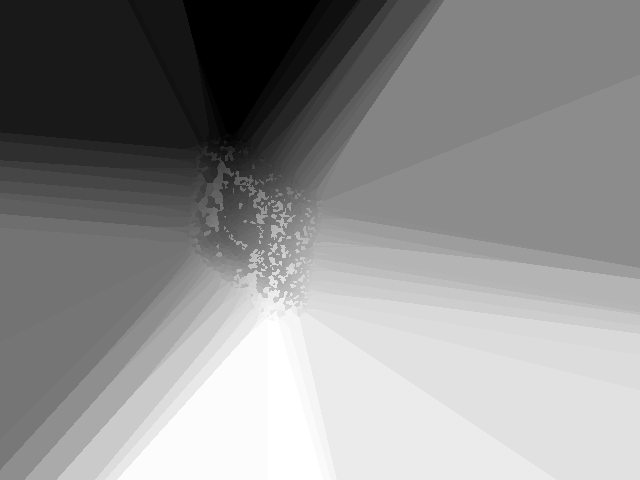

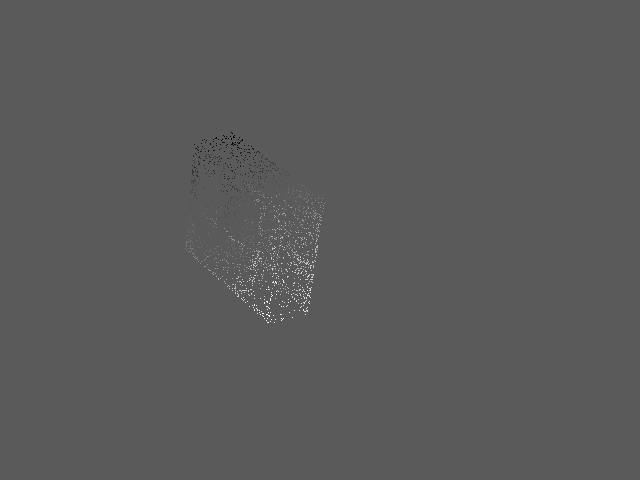

In [5]:

from scipy.interpolate import griddata

grid_x, grid_y = np.mgrid[0:h, 0:w]

grid_z0 = griddata(uv2, mapping[:,0], (grid_x, grid_y), method='nearest')
# shift_map2 = np.zeros( shift_map.shape ) 
# for u in range(u_min,u_max):
#     mi = int(torch.min(mapping[:,0]))
#     ma = int(torch.max(mapping[:,0]))
#     mi2 = int(torch.min(mapping[:,1]))
#     ma2 = int(torch.max(mapping[:,1]))
#     for v in range(v_min,v_max):
#         shift_map2[u,v, 0] = max(mi, min(ma, f_u(u,v)))
#         shift_map2[u,v, 1] = max(mi2, min(ma2, f_u(u,v)))
# #         print(f'val {int( max(mi, min(ma, f_u(u,v))))}')
shift_map_img = grid_z0 - np.min(grid_z0)
shift_map_img = shift_map_img / np.max(shift_map_img) *255
sm_img = Image.fromarray(np.uint8(shift_map_img))
display(sm_img)

shift_map_img = shift_map[:,:,0] - np.min(shift_map[:,:,0])
shift_map_img = shift_map_img / np.max(shift_map_img) *255
sm_img = Image.fromarray(np.uint8(shift_map_img))
display(sm_img)

# TODO get mesh from correctly transformed pointcloud for real and rendered image. 
# Calculate with simple projection for each pixel the crosponding mesh id aswell 3D point. 
# Do this for both images. -> search for ech pixel if a mesh with the same id in the other image has been 'hit' by a ray. 
# If so we have now a corrspondence between two pixel coordinates and also the information of the 3D point !


In [6]:
# analyze the mesh info we already have

import os
os.environ["PYOPENGL_PLATFORM"] = "egl"
import numpy as np
import trimesh
import pyrender
from random import choice
import random 
import PIL
from pathlib import Path
import pywavefront
import trimesh

p = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/models'
cad_models = [str(p) for p in Path(p).rglob('*.obj')]
print(cad_models[3])
mesh = trimesh.load(cad_models[3])

/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/models/019_pitcher_base/textured.obj


In [7]:

h= 480
w= 640
cx = 312.9869
cy = 241.3109
fx = 1066.778
fy = 1067.487
K = np.array([[fx,0,cx],[0,fy,cy],[0,0,1]])
u_cor = np.arange(0,h,1)
v_cor = np.arange(0,w,1)
point = np.array( [0,0,1] )
image_plane = K @ point
K_inv = np.linalg.inv(K)

start = np.zeros((h,w,3))
stop = np.zeros((h,w,3))
rays_dir = np.zeros((h*w,3))
nr = 0 
rays_origin_render = np.zeros((h*w,3))
rays_origin_real = np.zeros((h*w,3))
nr_to_image_plane = np.zeros((h*w,2), dtype=np.float)
for u in u_cor:
    for v in v_cor:
        start[u,v] = K_inv @ np.array([u,v, 1])  * 0.6
        stop[u,v] = (K_inv @ np.array([u,v, 1])) * 0.25
        rays_dir[nr,:] = start[u,v] - stop[u,v]
        rays_origin_render[nr,:] = K_inv @ np.array([u,v, 1])  * 0.1
        rays_origin_real[nr,:] = K_inv @ np.array([u,v, 1])  * 0.25
        nr_to_image_plane[nr, 0] = u
        nr_to_image_plane[nr, 1] = v
        nr += 1

        

In [8]:
import numpy as np
import k3d
def plot_line(start,stop):
    plot = k3d.plot(camera_auto_fit=False)
    nr = 0
    for u in range(0,h,50):
        for v in range(0,w,50):
    #         nr +=1 
    #         if nr > 50:
    #             break
            plt_line = k3d.line([start[u,v],stop[u,v]],shader='mesh', width=0.001, color=0xff0000)
            plot += plt_line
    plot.display()

In [9]:
def transform_mesh(mesh, H):
    """ directly operates on mesh and does not create a copy!"""
    t = np.ones((mesh.vertices.shape[0],4)) 
    t[:,:3] = mesh.vertices
    mesh.vertices = (t @ H.T)[:,:3]
    return mesh
    
H = np.eye(4)
H[:3,3] = [0,0,0.4]
print(H)

mesh = transform_mesh(mesh,H)
mesh.vertices

[[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0.4]
 [0.  0.  0.  1. ]]


TrackedArray([[ 0.      ,  0.044626,  0.382473],
              [ 0.      , -0.0219  ,  0.46985 ],
              [ 0.016384, -0.068607,  0.46036 ],
              ...,
              [-0.023593,  0.025253,  0.255077],
              [-0.023593, -0.067229,  0.279125],
              [-0.007209, -0.068784,  0.48748 ]])

In [10]:
# from trimesh.ray.ray_triangle import RayMeshIntersector
# from trimesh.ray.ray_pyembree import RayMeshIntersector
# import time

# ray_origins = np.zeros((h*w,3))
# rmi2 = RayMeshIntersector(mesh)

# st = time.time()
# nr = w*h
# coo = rmi2.intersects_location(ray_origins=ray_origins[:], ray_directions=direction[:], multiple_hits=False)
# print(f'Total time {time.time()-st}')

# ray_origins = np.zeros((h,w,3))
# stop = coo[0]
# # print(coo[1])
# # stop.reshape(h,w,3)
# len(coo[1])
# # # start[coo[1]]
# # for i in range(0,len(coo[1]),100):
# # i = 0
# #     plt_line = k3d.line([np.array( [0,0,0]), coo[0][i] ],shader='mesh', width=0.001, color=0xff0000)
# #     plot += plt_line
# # plot.display()
# # plot_line(start[coo[1]],stop)

# stop[0::10]
# import k3d
# plot = k3d.plot(camera_auto_fit=False)
# for i in range(0,len(coo[0]),int(len(coo[0])/50)):
#     plt_line = k3d.line([np.array( [0,0,0]), np.array(coo[0][i]) ],shader='mesh', width=0.001, color=0xff0000)
#     plot += plt_line
    
    
# for i in range(0,mesh.vertices.shape[0],int(mesh.vertices.shape[0]/50)):
#     plt_line = k3d.points(positions=mesh.vertices[i], point_size=0.005)
#     plot += plt_line
# display(plot)

NameError: name 'direction' is not defined

In [11]:
batch = dataset_train[0][0]
points, choose, img, target, model_points, idx = batch[0:6]
depth_img, label_img, img_orig, cam = batch[6:10]
gt_rot_wxyz, gt_trans, unique_desig = batch[10:13]
real_img, render_img, real_d, render_d, gt_label_cropped, pred_rot_wxyz, pred_trans, pred_points, h_ren, img_ren = batch[13:]
img_ren = img_ren[0]

In [13]:
import copy
# Load correct mesh accroding to desig
obj = list(dataset_train._backend._name_to_idx.keys())[unique_desig[1]-1]
for m in cad_models:
    if m.find(obj) != -1:
        mesh = trimesh.load(m)

# Make copy to transform the mesh
m_real = copy.deepcopy(mesh)
m_render = copy.deepcopy(mesh)
h_render = h_ren[0].numpy()

def get_homo_np(q, t):
    print()
    h = np.eye(4)
    h[:3,:3] =  quat_to_rot( torch.tensor( q ) ).numpy()
    h[:3,3] = t
    return h

h_real= get_homo_np( gt_rot_wxyz[None,:], gt_trans[None,:] )
transform_mesh(m_real, h_real)
transform_mesh(m_render, h_render)

print(m_real.vertices)
print(m_render.vertices)

from trimesh.ray.ray_triangle import RayMeshIntersector
from trimesh.ray.ray_pyembree import RayMeshIntersector

rays_dir
rmi_real = RayMeshIntersector(m_real)
rmi_render = RayMeshIntersector(m_render)
nr = w*h

import time; st = time.time()
render_res = rmi_render.intersects_location(ray_origins=rays_origin_render, 
                               ray_directions=rays_dir,
                               multiple_hits=False)
real_res = rmi_real.intersects_location(ray_origins=rays_origin_real, 
                               ray_directions=rays_dir,
                               multiple_hits=False)
# real_res contains: points, mesh, ray

print(f'Total time {time.time()-st}')

render = np.zeros( (h,w,3) )
real = np.zeros( (h,w,3) )

#coordinate of point in 3D + descriptor(mesh index)
render_des = np.zeros( (h,w,4) ) 
real_des = np.zeros( (h,w,4) )


for i in range(real_res[1].shape[0]):
    
    # Todo why do we have to do the index swapping here ?
    # might it be that something is simply mirrored in some sense ? 
    
    u = int(nr_to_image_plane[ real_res[1][i] ][1])
    v = int(nr_to_image_plane[ real_res[1][i] ][0])
    real[u,v] = np.linalg.norm( real_res[0][i], ord=2)
    real_des[u,v,:3] = np.array( real_res[0][i] )
    real_des[u,v,3] = real_res[2][i]
    
for i in range(render_res[1].shape[0]):
    u = int(nr_to_image_plane[ render_res[1][i] ][1])
    v = int(nr_to_image_plane[ render_res[1][i] ][0])
    render[u,v] = np.linalg.norm( render_res[0][i], ord=2)
    render_des[u,v,:3] = np.array( render_res[0][i] )
    render_des[u,v,3] = render_res[2][i]
print('done')


[[-0.01749012  0.00694044  0.59851002]
 [-0.01483299  0.02060404  0.56280025]
 [-0.04740291  0.02234211  0.6060686 ]
 ...
 [-0.01283595 -0.01288239  0.58400369]
 [-0.0278409  -0.01927606  0.60161062]
 [-0.0331179  -0.02143235  0.60756274]]
[[ 0.01344323  0.01406621  0.40726269]
 [ 0.01457112  0.03246476  0.37365966]
 [-0.01604998  0.02822601  0.41816081]
 ...
 [ 0.01737965 -0.00358893  0.39000465]
 [ 0.00314342 -0.0123529   0.40722539]
 [-0.0018735  -0.01531101  0.4130567 ]]
Total time 1.6765499114990234
done


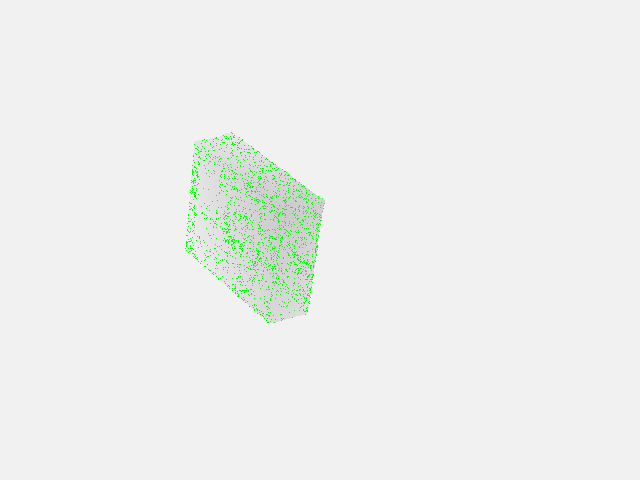

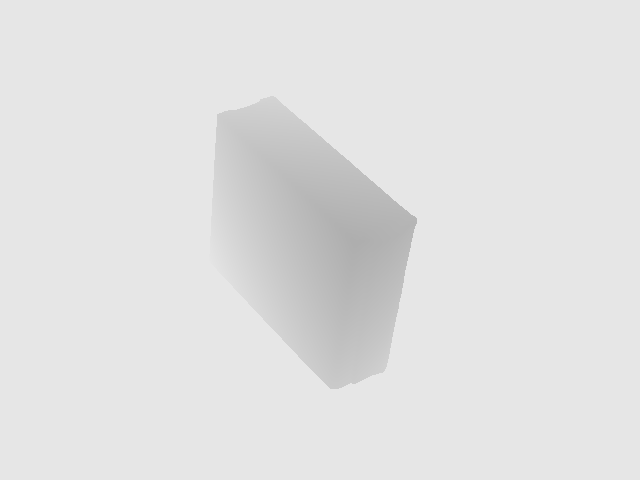

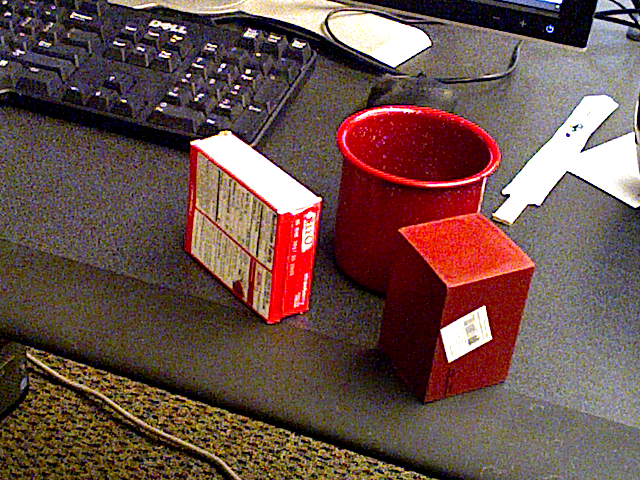

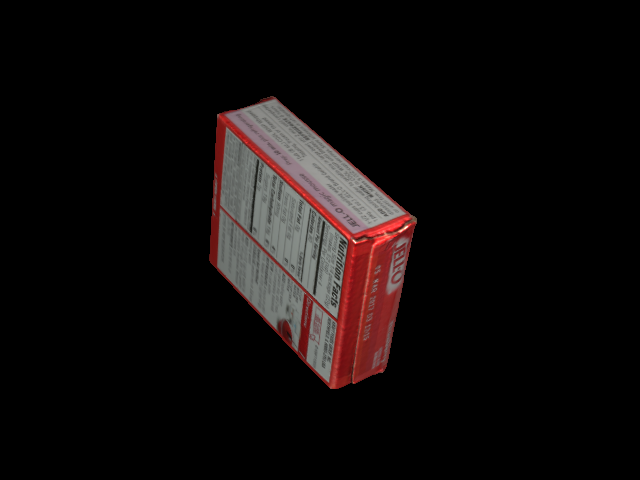

In [14]:
from PIL import Image
ind = real != 0
mind = np.min( real[ind] )
d = 10
real_scaled = (real-mind+d) * (255/np.max(real))
ind = real_scaled < d
real[ind] = 0

for p in uv2.tolist():
    try:
        real_scaled[p[0],p[1],0] = 0
        real_scaled[p[0],p[1],1] = 255
        real_scaled[p[0],p[1],2] = 0
    except:
        pass
im = Image.fromarray(np.uint8(real_scaled))
display(im)

ind = render != 0
mind = np.min( render[ind] )
render_scaled = (render-mind+d) * (255/np.max(render))
ind = render_scaled < d
render_scaled[ind] = 0
im2 = Image.fromarray(np.uint8(render_scaled))
display(im2)

display(Image.fromarray(np.uint8(img_orig)))
display(Image.fromarray(np.uint8(img_ren)))

In [15]:
# plot a mesh corrspondence image
#coordinate of point in 3D + descriptor(mesh index)
# render_des[u,v,3]
# real_des[u,v,3]
# nr = -10000
# while nr-1 != np.max(render_des[:,:,3]):
#     m = int( np.max(render_des[:,:,3]) )
#     render_des[ render_des[:,:,3] == m] = nr
#     real_des[ real_des[:,:,3] == m] = nr
    
#     if nr % 100 == 0:
#         print(nr,m)
#     nr += 1
# real_des[real_des > 0] = -10001
# render_des += 10001
# real_des += 10001
if np.max(render_des[:,:,3] ) > np.max( real_des[:,:,3] ):
    lim = np.max( real_des[:,:,3] )
else:
    lim = np.max(render_des[:,:,3] )
render_des[:,:,3][ render_des[:,:,3] > lim] = lim
real_des[:,:,3][ real_des[:,:,3] > lim] = lim

if np.min(render_des[:,:,3][render_des[:,:,3] !=  0] ) > np.min( real_des[:,:,3][real_des[:,:,3] !=  0]):
    lim = np.min( render_des[:,:,3][render_des[:,:,3] !=  0] )
else:
    lim = np.min( real_des[:,:,3][real_des[:,:,3] !=  0])

render_des[:,:,3][ render_des[:,:,3] < lim] = lim
real_des[:,:,3][ real_des[:,:,3] < lim] = lim



print('Done')

Done


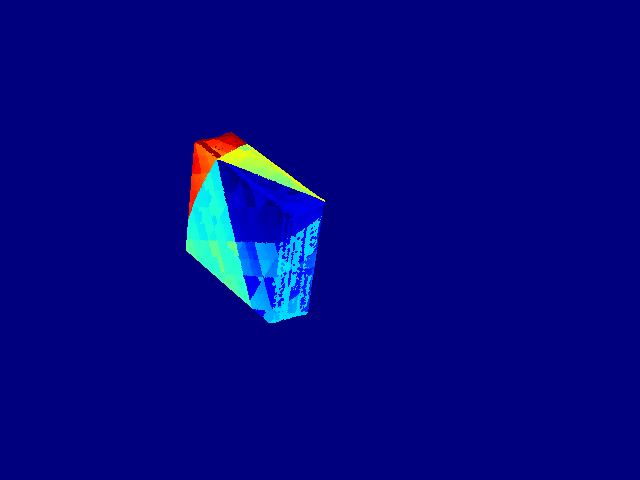

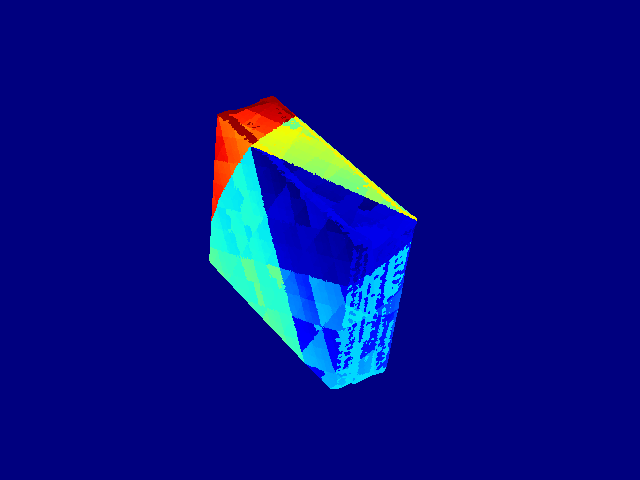

In [16]:
from matplotlib import cm
# plot the corrosponding meshed !
jet = cm.get_cmap('jet')
c = int( max( np.max(real_des[:,:,3]), np.max(render_des[:,:,3])) ) +1
SEG_COLORS = (np.stack([jet(v) for v in np.linspace(0, 1, c)]) * 255).astype(np.uint8)

def plot(label):
    image_out = np.zeros(
    (label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for h in range(label.shape[0]):
        for w in range(label.shape[1]):
            image_out[h, w, :] = SEG_COLORS[int(label[h, w])][:3]
    display(Image.fromarray(np.uint8(image_out)))
    return image_out

im_out2 = plot(real_des[:,:,3])
im_out = plot(render_des[:,:,3])


In [17]:
nr = 0
disparity = np.zeros((h,w,3))
disparity_pixels = np.zeros((h,w,2)) - 999
for _w in range(w-1):
    for _h in range(h-1):
        if real_des[_h,_w,3] != 17:
            ind = (render_des[:,:,3] == real_des[_h,_w,3])[:,:,None].repeat(4,2)
            ind[:,:,3] = False 
            
            cor_points = render_des[ind].reshape(-1,3)
            if cor_points.shape[0] != 0:
                res = np.where(ind == True) 
                u = res[0][0]
                v = res[1][0]
                disparity_pixels[_h,_w,0] = u - _h
                disparity_pixels[_h,_w,1] = v - _w
#                 print( cor_points, f'For Value{real_des[_h,_w,3]}, mean { np.mean(cor_points, axis= 0)}')
                disparity[_h,_w,:] = real_des[_h,_w,:3] - np.mean(cor_points, axis= 0)
                nr += 1
#         if nr > 100:
#             break
#     if nr > 100:
#             break


-0.0320794168875505 0.1993796585486034


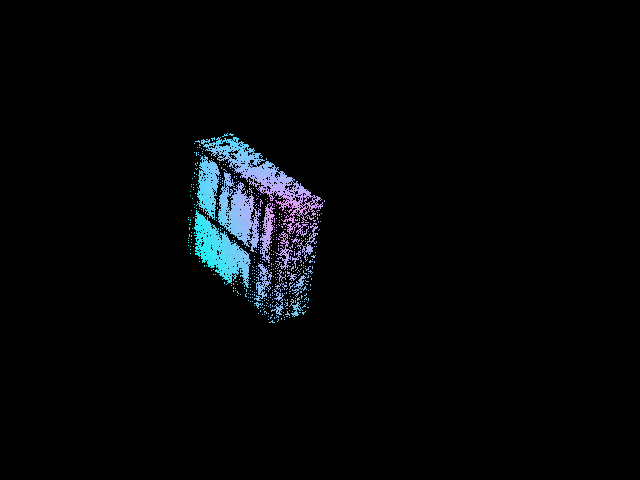

In [19]:

def disp_img(img):
    img[:,:,0] = img[:,:,0] - np.min(img[:,:,0])
    img[:,:,0] = img[:,:,0] / (np.max(img[:,:,0])/255.0)
    img[:,:,1] = img[:,:,1] - np.min(img[:,:,1])
    img[:,:,1] = img[:,:,1] / (np.max(img[:,:,1])/255.0)
    img[:,:,2] = img[:,:,2] - np.min(img[:,:,2])
    img[:,:,2] = img[:,:,2] / (np.max(img[:,:,2])/255.0)
    display(Image.fromarray(np.uint8(img)))

a = np.min( disparity[disparity != 0] )
disparity[disparity == 0] = a
print( np.min( disparity),np.max( disparity) )
disp_img(disparity)

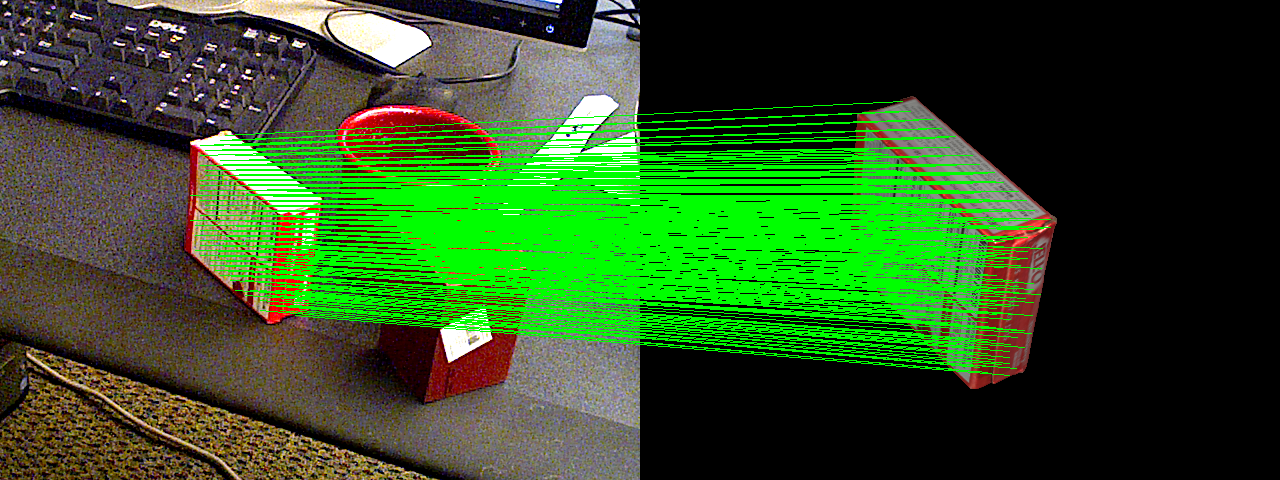

In [20]:
big = np.concatenate( [img_orig, img_ren], axis=1) 

img = Image.fromarray(np.uint8(big))
draw = ImageDraw.Draw(img)


col = (0, 255, 0)
grey = (207, 207, 207)
for _w in range(0,w,5):
    for _h in range(0,h,5):
        
        if label_img[_h,_w] == unique_desig[1] and (disparity_pixels[_h,_w,0] != -999 or disparity_pixels[_h,_w,1] != -999):
            try:

                draw.line([(_w, _h), (_w + disparity_pixels[_h,_w,1]+640, _h + disparity_pixels[_h,_w,0])],
                  fill=col, width=1)
    #         draw.ellipse([(v - a, u - a), (v + a, u + a)],
    #                  outline=grey, fill=grey, width=2)
            except:
                pass
display(img)

(480, 640) (480, 640) (480, 640, 2)
(9488, 2)
(480, 640, 3)


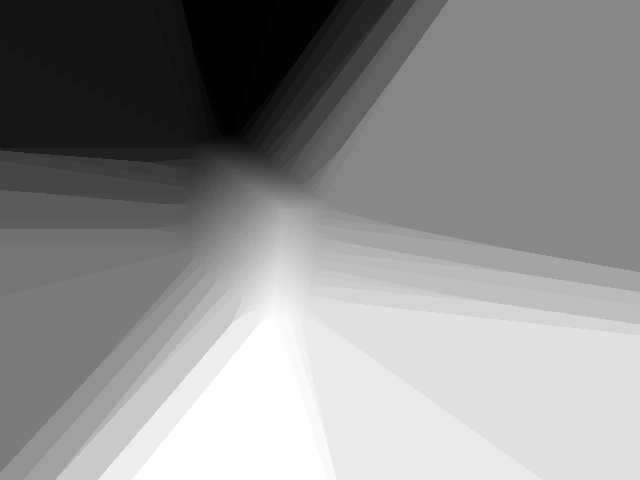

In [59]:
label_img.shape

from scipy.interpolate import griddata


f_1 = label_img.numpy() == int( unique_desig[1])
f_2 = disparity_pixels[:,:,0] != -999

f_3 = f_1*f_2
points = np.where(f_3!=False)
points = np.stack( [np.array(points[0]), np.array( points[1]) ], axis=1)

# print(f_3[:,:,None].repeat(3,3).shape)
# o = f_3[:,:,None](1,1,2)
print(f_1.shape, f_2.shape , disparity_pixels.shape)
print( disparity_pixels[f_3].shape )

grid_x, grid_y = np.mgrid[0:h, 0:w]
grid_z0 = griddata(points, disparity_pixels[f_3][:,0], (grid_x, grid_y), method='nearest')
o = np.repeat( np.expand_dims(grid_z0,2),3,2)
print(o.shape)
disp_img(o)